# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [397]:
# Installing Libraries
# !pip install scikit-learn matplotlib Pillow
!which python

/Users/apappu/.pyenv/shims/python


In [398]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [399]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [400]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [401]:
# Loading the dataset

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]


dirpath_cfw = './dataset/IIIT-CFW/'
X_cfw,y_cfw = load_data(dirpath_cfw)
N_cfw,H_cfw,W_cfw = X_cfw.shape[0:3]
C_cfw = 1 if opt['is_grayscale'] else X_cfw.shape[3]

dirpath_imfdb = './dataset/IMFDB/'
X_imfdb,y_imfdb = load_data(dirpath_imfdb)
N_imfdb,H_imfdb,W_imfdb = X_imfdb.shape[0:3]
C_imfdb = 1 if opt['is_grayscale'] else X_imfdb.shape[3]


dirpath_yale = './dataset/Yale_face_database/'
X_yale,y_yale = load_data(dirpath_yale)
N_yale,H_yale,W_yale = X_yale.shape[0:3]
C_yale = 1 if opt['is_grayscale'] else X_yale.shape[3]



Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


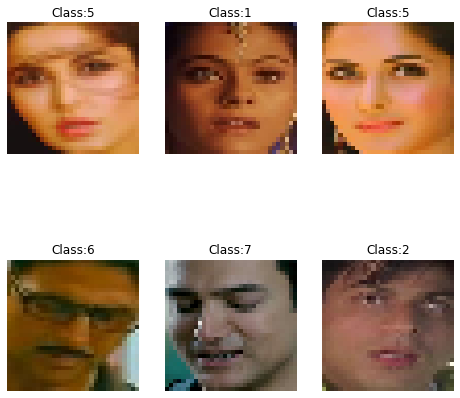

In [402]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [403]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [404]:
X_cfw = X_cfw.reshape((N_cfw,H_cfw*W_cfw*C_cfw))
X_imfdb = X_imfdb.reshape((N_imfdb,H_imfdb*W_imfdb*C_imfdb))
X_yale = X_yale.reshape((N_yale,H_yale*W_yale*C_yale))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [405]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [406]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [407]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [408]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [409]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [410]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [411]:
# Compute your features 
# eg.
X_3D = get_kernel_lda(X,y,3)

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


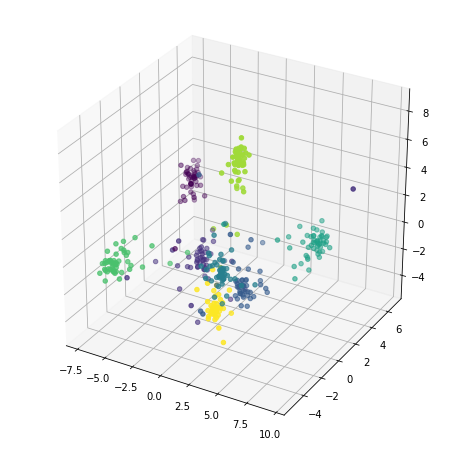

In [412]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

Variance covered by top 75 eigen vectors:  0.9104227741324731


Text(0, 0.5, 'Eigen Values')

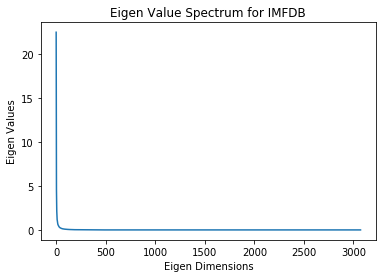

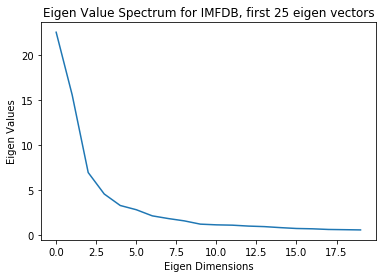

In [413]:
# Eigen value spectrum 

X_cov = np.cov(X_imfdb.T)
eigval, eigvec = linalg.eigh(X_cov)
eigval[::-1].sort()

plt.figure()
plt.title('Eigen Value Spectrum for IMFDB')
plt.plot(range(len(eigval)), eigval)
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

print("Variance covered by top 75 eigen vectors: ", eigval[:75].sum()/eigval.sum())

plt.figure()
plt.title('Eigen Value Spectrum for IMFDB, first 25 eigen vectors')
plt.plot(range(20), eigval[:20])
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

Variance covered by top 200 eigen vectors:  0.8950577717917676


Text(0, 0.5, 'Eigen Values')

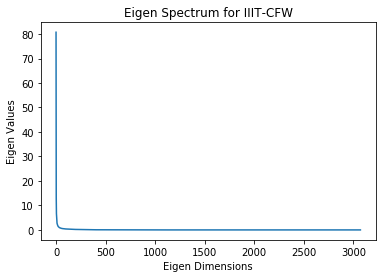

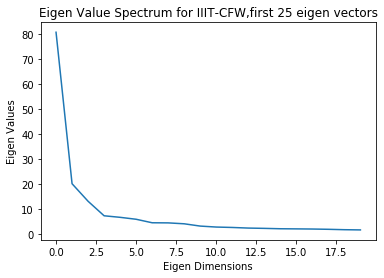

In [414]:
# Eigen value spectrum - IIIT-CFW

X_cov = np.cov(X_cfw.T)
eigval, eigvec = linalg.eigh(X_cov)
eigval[::-1].sort()

plt.figure()
plt.title('Eigen Spectrum for IIIT-CFW')
plt.plot(range(len(eigval)), eigval)
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

print("Variance covered by top 200 eigen vectors: ", eigval[:200].sum()/eigval.sum())

plt.figure()
plt.title('Eigen Value Spectrum for IIIT-CFW,first 25 eigen vectors')
plt.plot(range(20), eigval[:20])
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

Variance covered by top 35 eigen vectors:  0.9006688201621897


Text(0, 0.5, 'Eigen Values')

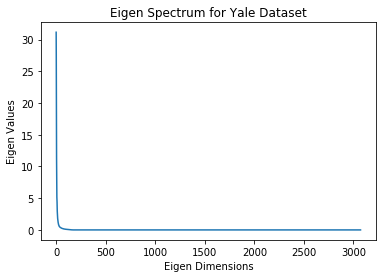

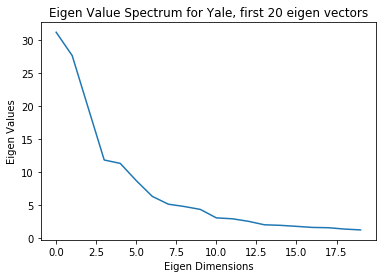

In [415]:
# Eigen value spectrum - Yale Database
X_cov = np.cov(X_yale.T)
eigval, eigvec = linalg.eigh(X_cov)
eigval[::-1].sort()

plt.figure()
plt.title('Eigen Spectrum for Yale Dataset')
plt.plot(range(len(eigval)), eigval)
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

print("Variance covered by top 35 eigen vectors: ", eigval[:35].sum()/eigval.sum())

plt.figure()
plt.title('Eigen Value Spectrum for Yale, first 20 eigen vectors')
plt.plot(range(20), eigval[:20])
plt.xlabel("Eigen Dimensions")
plt.ylabel("Eigen Values")

1(c). Reconstruct  the  image  back for each case


In [416]:
# Function to reconstruct images using Eigen Vectors
def reconstruction(X, data_str):
    X_cov = np.cov(X.T)
    eigval, eigvec = linalg.eigh(X_cov)
    
    if data_str == 'IMFDB':
        n_eigvectors = 75
    elif data_str == 'IIIT-CFW':
        n_eigvectors = 150
    elif data_str == 'Yale':
        n_eigvectors = 42
    else:
        print("Data source not Initialized.")
        return None
    X_transformed = X.dot(eigvec[:,:n_eigvectors])
    X_reconstructed = X_transformed.dot(eigvec[:,:n_eigvectors].T)
    
    return X_reconstructed

# Function to compute reconstruction error based on input data and reconstructed data
def reconstructionerror(X, X_reconstructed):
    return np.sqrt(np.mean((X - X_reconstructed)**2))

In [417]:
# Display results 
# X_reconstruced = reconstruction()

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)

X_imfdb_rec = reconstruction(X_imfdb, "IMFDB")
X_cfw_rec = reconstruction(X_cfw, "IIIT-CFW")
X_yale_rec = reconstruction(X_yale, "Yale")

rec_error_imfdb = reconstructionerror(X_imfdb, X_imfdb_rec)
rec_error_cfw = reconstructionerror(X_cfw, X_cfw_rec)
rec_error_yale = reconstructionerror(X_yale, X_yale_rec)

# Show the reconstruction error
print("Reconstruction Error for the 3 Datasets : ")
print("IMFDB: ", rec_error_imfdb)
print("IIIT-CFW: ", rec_error_cfw)
print("Yale Database", rec_error_yale)

Reconstruction Error for the 3 Datasets : 
IMFDB:  0.4349932831257429
IIIT-CFW:  0.7028680317734811
Yale Database 0.6426351769982345


1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [418]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
# Classifier class would then be used to build train, validation functions

#Wrapper Method to allow on the fly inheritence 
def ClassifierWrapperMethod(cls):
    
    class Classifier(cls):
        def __init__(self, n_features = None, conf_matrix = None,
                     classification_report = None, classification_error = None, 
                     accuracy = None, precision = None, recall = None, results = None):
            super().__init__()
            self.n_features = n_features
            self.conf_matrix = conf_matrix
            self.classification_report = classification_report
            self.precision = precision
            self.recall = recall
            self.accuracy = accuracy
            self.classification_error = classification_error
            self.results = results

        def classify(self,X):
            prediction = self.predict(X)
            return prediction

        def confusion_matrix(self,pred,y):
            return metrics.confusion_matrix(y, pred)
            
        def train(self,X_train,y_train):
            self.n_features = X_train.shape[1]
            self.fit(X_train, y_train)  
            
        def validate(self,X_validate,y_validate):
            
            y_val_pred = self.predict(X_validate)
            
            # Create a confusion matrix
            self.conf_matrix = metrics.confusion_matrix(y_validate, y_val_pred)

            # Calculate Validation accuracy 
            self.accuracy = metrics.accuracy_score(y_validate, y_val_pred)
            self.classification_error = 1 - self.accuracy
            
            # Calculate precision and recall 
            self.classification_report = pd.DataFrame(metrics.
                                                      classification_report(y_validate,
                                                                            y_val_pred,
                                                                            output_dict = True))
            self.precision = self.classification_report["weighted avg"]["precision"]
            self.recall = self.classification_report["weighted avg"]["recall"]            
        
        def collate(self, str):
            results_cols = ['Features', 'Feature Space', 'Classification Error', 
                            'Accuracy']
      
            results_data = np.array([str, self.n_features, self.classification_error, 
                                   self.accuracy]).reshape([1, 4])
            results = pd.DataFrame(data = results_data, columns = results_cols)
            
            return results
            
    return Classifier

In [441]:
# Create a train and validation split to train your classifier 

def Classify(X, y, dirpath):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 45)

    result = pd.DataFrame(columns = ['Features', 'Feature Space', 
                                     'Classification Error', 'Accuracy'])

    
    
    C1 = ClassifierWrapperMethod(LogisticRegression)()
    C2 = ClassifierWrapperMethod(SVC)()
    C3 = ClassifierWrapperMethod(MLPClassifier)()
    C4 = ClassifierWrapperMethod(SVC)()
    C5 = ClassifierWrapperMethod(MLPClassifier)()
    C6 = ClassifierWrapperMethod(MLPClassifier)()
    C7 = ClassifierWrapperMethod(MLPClassifier)()
    C8 = ClassifierWrapperMethod(SVC)()
    C9 = ClassifierWrapperMethod(MLPClassifier)()
    
    

    C1.train(X_train, y_train)
    C1.validate(X_test, y_test)
    result = result.append(C1.collate('Logistic Regression'))

    C2.train(X_train, y_train)
    C2.validate(X_test, y_test)
    result = result.append(C2.collate('Support Vector Machines'))


    C3.train(X_train, y_train)
    C3.validate(X_test, y_test)
    result = result.append(C3.collate('MLP')) 
    X_train_pca = get_pca(X_train, 42)
    X_test_pca = get_pca(X_test, 42)
    
    
    C4.train(X_train_pca, y_train)
    C4.validate(X_test_pca, y_test)
    result = result.append(C4.collate('PCA, SVM'))

    
    X_train_klda = get_kernel_lda(X_train, y_train, 3000, 'rbf', degree = 3000)
    X_test_klda = get_kernel_lda(X_test, y_test, 3000, 'rbf', degree = 3000)
    C5.train(X_train_klda, y_train)
    C5.validate(X_test_klda, y_test)
    result = result.append(C5.collate('kernel LDA + MLP'))

    
    X_vgg = get_vgg_features(dirpath)
    X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y, test_size = 0.25, random_state = 76)
    C6.train(X_train_vgg, y_train_vgg)
    C6.validate(X_test_vgg, y_test_vgg)
    result = result.append(C6.collate('VGG + MLP'))

    
    X_res = get_resnet_features(dirpath)
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y, test_size = 0.25, random_state = 76)
    C7.train(X_train_res, y_train_res)
    C7.validate(X_test_res, y_test_res)
    result = result.append(C7.collate('ResNet + MLP'))


    X_vgg_res = np.append(X_vgg, X_res, axis = 1)
    X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_vgg_res, y, test_size = 0.25, random_state = 76)
    C8.train(X_train_rv, y_train_rv)
    C8.validate(X_test_rv, y_test_rv)
    result = result.append(C8.collate('VGG, ResNet + SVM'))

    
    X_vgg_res = np.append(X_vgg, X_res, axis = 1)
    X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_vgg_res, y, test_size = 0.25, random_state = 76)
    C9.train(X_train_rv, y_train_rv)
    C9.validate(X_test_rv, y_test_rv)
    result = result.append(C9.collate('VGG, ResNet + MLP'))

    return result.set_index('Features')



result_imfdb = Classify(X_imfdb, y_imfdb, dirpath_imfdb)
result_cfw = Classify(X_cfw, y_cfw, dirpath_cfw)
result_yale = Classify(X_yale, y_yale, dirpath_yale)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/l

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

In [442]:
result_imfdb

,Feature Space,Classification Error,Accuracy
Features,,,
Logistic Regression,3072,0.12,0.88
Support Vector Machines,3072,0.65,0.35
MLP,3072,0.15000000000000002,0.85
"PCA, SVM",42,0.7,0.3
kernel LDA + MLP,7,0.5800000000000001,0.42
VGG + MLP,4096,0.10999999999999999,0.89
ResNet + MLP,2048,0.040000000000000036,0.96
"VGG, ResNet + SVM",6144,0.020000000000000018,0.98
"VGG, ResNet + MLP",6144,0.020000000000000018,0.98


In [443]:
result_cfw

,Feature Space,Classification Error,Accuracy
Features,,,
Logistic Regression,3072,0.5238095238095238,0.47619047619047616
Support Vector Machines,3072,0.6011904761904762,0.39880952380952384
MLP,3072,0.5119047619047619,0.4880952380952381
"PCA, SVM",42,0.8035714285714286,0.19642857142857142
kernel LDA + MLP,7,0.7440476190476191,0.25595238095238093
VGG + MLP,4096,0.29166666666666663,0.7083333333333334
ResNet + MLP,2048,0.023809523809523836,0.9761904761904762
"VGG, ResNet + SVM",6144,0.011904761904761862,0.9880952380952381
"VGG, ResNet + MLP",6144,0.029761904761904767,0.9702380952380952


In [444]:
result_yale

,Feature Space,Classification Error,Accuracy
Features,,,
Logistic Regression,3072,0.0714285714285714,0.9285714285714286
Support Vector Machines,3072,0.8571428571428572,0.14285714285714285
MLP,3072,0.0714285714285714,0.9285714285714286
"PCA, SVM",42,0.9761904761904762,0.023809523809523808
kernel LDA + MLP,14,0.9285714285714286,0.07142857142857142
VGG + MLP,4096,0.5238095238095238,0.47619047619047616
ResNet + MLP,2048,0.0,1.0
"VGG, ResNet + SVM",6144,0.023809523809523836,0.9761904761904762
"VGG, ResNet + MLP",6144,0.0,1.0


In [423]:
# For each dataset print the confusion matrix for the best model 

In [438]:
# Confusion Matrix for IMFDB - VGG, ResNet + SVM
C_IMFDB = ClassifierWrapperMethod(MLPClassifier)()
X_vgg = get_vgg_features(dirpath_imfdb)
X_res = get_resnet_features(dirpath_imfdb)
X_vgg_res = np.append(X_vgg, X_res, axis = 1)
X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_vgg_res, y_imfdb, 
                                                                test_size = 0.25, random_state = 45)
C_IMFDB.train(X_train_rv, y_train_rv)
C_IMFDB.validate(X_test_rv, y_test_rv)
print("Confusion Matrix for Best Model on IMFDB Data - VGG, ResNet + SVM")
C_IMFDB.conf_matrix

Confusion Matrix for Best Model on IMFDB Data - VGG, ResNet + SVM


array([[17,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  2],
       [ 0,  0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12]])

In [439]:
# Confusion Matrix for CFW - VGG, ResNet + SVM
C_CFW = ClassifierWrapperMethod(SVC)()
X_vgg = get_vgg_features(dirpath_cfw)
X_res = get_resnet_features(dirpath_cfw)
X_vgg_res = np.append(X_vgg, X_res, axis = 1)
X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_vgg_res, y_cfw,
                                                                test_size = 0.25, random_state = 45)
C_CFW.train(X_train_rv, y_train_rv)
C_CFW.validate(X_test_rv, y_test_rv)
print("Confusion Matrix for Best Model on IIIT-CFW Data - VGG, ResNet + SVM")
C_CFW.conf_matrix

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Confusion Matrix for Best Model on IIIT-CFW Data - VGG, ResNet + SVM


array([[12,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 25,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 25,  0,  0,  0,  1],
       [ 0,  0,  1,  0, 23,  0,  0,  1],
       [ 0,  0,  0,  0,  0, 24,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20]])

In [440]:
# Confusion Matrix for Yale Dataset - ResNet + MLP
C_YALE = ClassifierWrapperMethod(MLPClassifier)()
X_res = get_resnet_features(dirpath_yale)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_yale,
                                                                    test_size = 0.25, random_state = 45)
C_YALE.train(X_train_res, y_train_res)
C_YALE.validate(X_test_res, y_test_res)
print("Confusion Matrix for Best Model on Yale Data - ResNet + MLP")
C_YALE.conf_matrix

Confusion Matrix for Best Model on Yale Data - ResNet + MLP


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

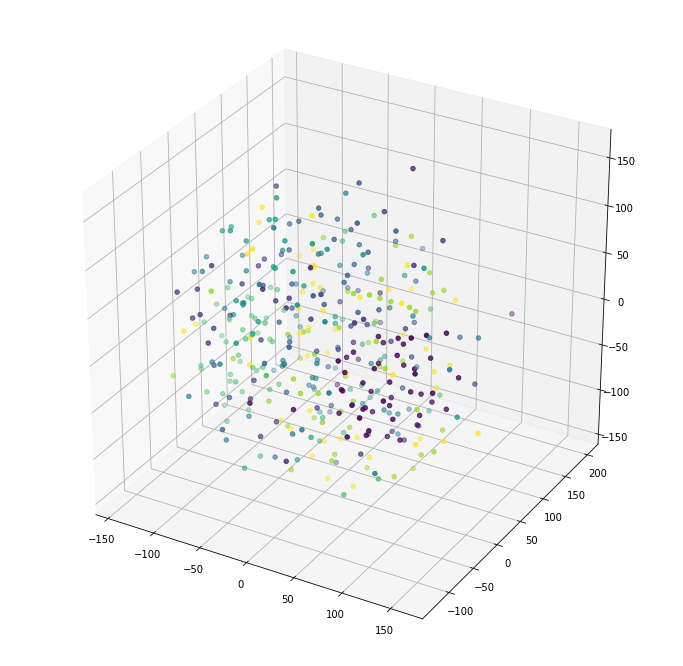

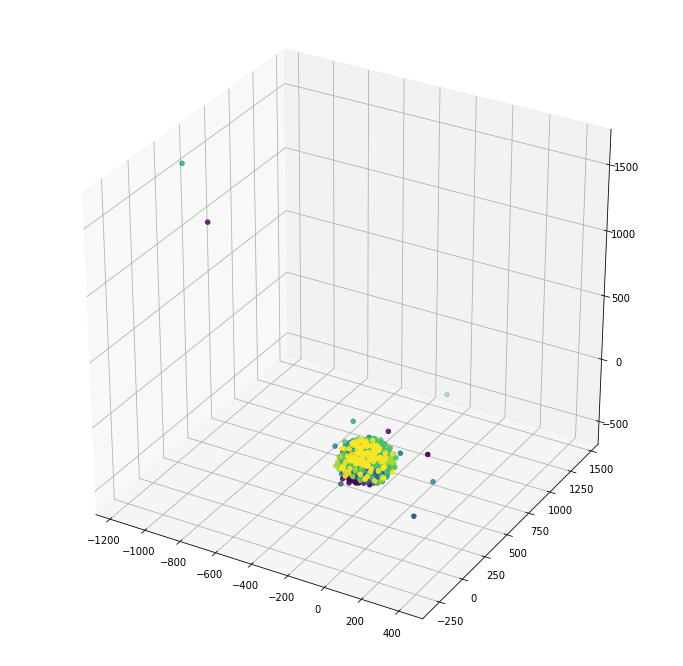

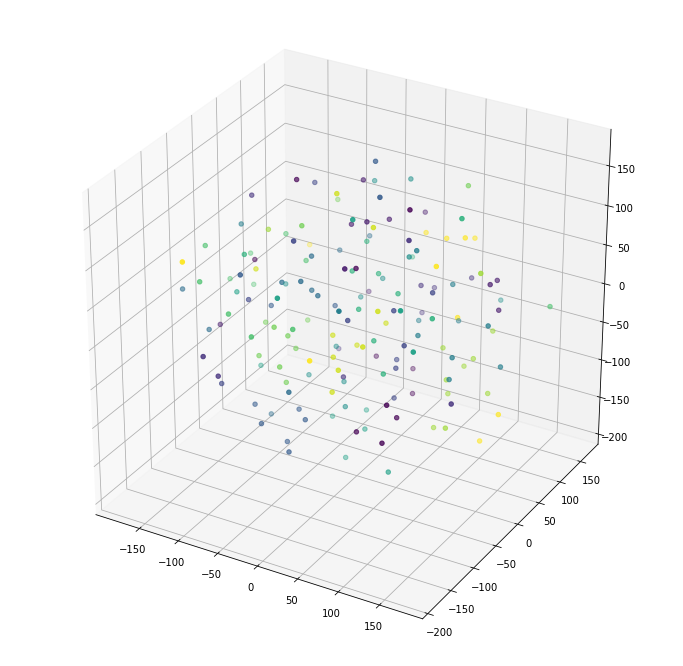

In [427]:
# Compute TSNE for different features and create a scatter plot

k = 3 # Number of components in TSNE

# IMFDB
X = X_imfdb 
X_TSNE = TSNE(n_components=k).fit_transform(X)


# Plot the representation in 2d/3d
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_imfdb)


# CFW
X = X_cfw 
X_TSNE = TSNE(n_components=k).fit_transform(X)


# Plot the representation in 2d/3d
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_cfw)


# YALE
X = X_yale 
X_TSNE = TSNE(n_components=k).fit_transform(X)


# Plot the representation in 2d/3d
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_yale)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [428]:
# kNN Classifier for FaceVerification Task
class FaceVerification(KNeighborsClassifier):
    def __init__(self, n_features = None, n_neighbors = 1, conf_matrix = None,
                 classification_report = None, verification_error = None, 
                 accuracy = None, precision = None, recall = None, results = None):
        super().__init__(n_neighbors= n_neighbors)
        self.n_features = n_features
        self.conf_matrix = conf_matrix
        self.classification_report = classification_report
        self.precision = precision
        self.recall = recall
        self.accuracy = accuracy
        self.verification_error = verification_error
        self.results = results
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        prediction = self.predict(X)
        verfication_results = (prediction == class_id)
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.n_features = X_train.shape[1]
        self.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        
        y_val_pred = self.predict(X_validate)
            
        # Create a confusion matrix
        self.conf_matrix = metrics.confusion_matrix(y_validate, y_val_pred)
        # Calculate Validation accuracy 
        self.accuracy = metrics.accuracy_score(y_validate, y_val_pred)
        self.verification_error = 1 - self.accuracy
        # Calculate precision and recall 
        cl_report = metrics.classification_report(y_validate, y_val_pred, output_dict = True)
        self.classification_report = pd.DataFrame(cl_report)
        self.precision = self.classification_report["weighted avg"]["precision"]
        self.recall = self.classification_report["weighted avg"]["recall"]

    def collate(self, str):
        results_cols = ['Features', 'Feature Space', 'Validation Error', 
                        'Accuracy', 'Precision']
      
        results_data = np.array([str, self.n_features, self.verification_error, 
                                self.accuracy, self.precision]).reshape([1, 5])
        results = pd.DataFrame(data = results_data, columns = results_cols)
            
        return results

In [429]:
# Create a train and validation split and show your results 
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

def VerifyFace(X, y, dirpath):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    results = pd.DataFrame(columns = ['Features', 'Feature Space', 
                                     'Validation Error', 'Accuracy', 'Precision'])

    C1 = FaceVerification(n_neighbors = 11)
    C2 = FaceVerification(n_neighbors = 11)
    C3 = FaceVerification(n_neighbors = 11)
    C4 = FaceVerification(n_neighbors = 11)
    
    
    C1.train(X_train, y_train)
    C1.validate(X_test, y_test)
    results = results.append(C1.collate('Raw Image Features + K=11'))

    
    X_vgg = get_vgg_features(dirpath)
    X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y, test_size = 0.25, random_state = 45)
    C2.train(X_train_vgg, y_train_vgg)
    C2.validate(X_test_vgg, y_test_vgg)
    results = results.append(C2.collate('VGG + K=11'))

    
    X_res = get_resnet_features(dirpath)
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y, test_size = 0.25, random_state = 45)
    C3.train(X_train_res, y_train_res)
    C3.validate(X_test_res, y_test_res)
    results = results.append(C3.collate('ResNet + K=11'))

    
    X_vgg_res = np.append(X_vgg, X_res, axis = 1)
    X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_vgg_res, y, test_size = 0.25, random_state = 45)
    C4.train(X_train_rv, y_train_rv)
    C4.validate(X_test_rv, y_test_rv)
    results = results.append(C4.collate('VGG, ResNet + K=11'))

    return results.set_index('Features')

results_imfdb = VerifyFace(X_imfdb, y_imfdb, dirpath_imfdb)
results_cfw = VerifyFace(X_cfw, y_cfw, dirpath_cfw)
results_yale = VerifyFace(X_yale, y_yale, dirpath_yale)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [430]:
results_imfdb

,Feature Space,Validation Error,Accuracy,Precision
Features,,,,
Raw Image Features + K=11,3072,0.5375,0.4625,0.7117524279448622
VGG + K=11,4096,0.09999999999999998,0.9,0.9123076923076923
ResNet + K=11,2048,0.06999999999999995,0.93,0.9400549450549451
"VGG, ResNet + K=11",6144,0.050000000000000044,0.95,0.9568431568431568


In [431]:
results_cfw

,Feature Space,Validation Error,Accuracy,Precision
Features,,,,
Raw Image Features + K=11,3072,0.674074074074074,0.32592592592592595,0.462483164983165
VGG + K=11,4096,0.33333333333333337,0.6666666666666666,0.6798004370830458
ResNet + K=11,2048,0.0357142857142857,0.9642857142857143,0.9659318855747427
"VGG, ResNet + K=11",6144,0.023809523809523836,0.9761904761904762,0.9781545614878949


In [432]:
results_yale

,Feature Space,Validation Error,Accuracy,Precision
Features,,,,
Raw Image Features + K=11,3072,0.303030303030303,0.696969696969697,0.7449494949494949
VGG + K=11,4096,0.5238095238095238,0.47619047619047616,0.7345238095238096
ResNet + K=11,2048,0.0,1.0,1.0
"VGG, ResNet + K=11",6144,0.19047619047619047,0.8095238095238095,0.9294217687074829


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [433]:
# Load data

In [434]:
# Define your features

In [435]:
# Create your classifier

# Validate your classifier

In [436]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  

In [437]:
# Show quantitative results such as examples of correct prediction and wrong prediction